In [32]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
df = pd.read_csv("heart_cleveland_upload.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


ANÁLISE EXPLORATORIA DE DADOS

In [3]:
#Verifica valores ausentes e tipos de valores
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [4]:
#Verifica quantos possuem ou não doenças cardíacas (0 = não possui, 1 = possui)
df["condition"].value_counts()

condition
0    160
1    137
Name: count, dtype: int64

In [5]:
#Verifica quantos pacientes possuem doenças cardiacas, mas agora separados por genero (1=home, 0= mulher)
pd.crosstab(df["condition"], df["sex"])


sex,0,1
condition,,
0,71,89
1,25,112


<Axes: xlabel='cp'>

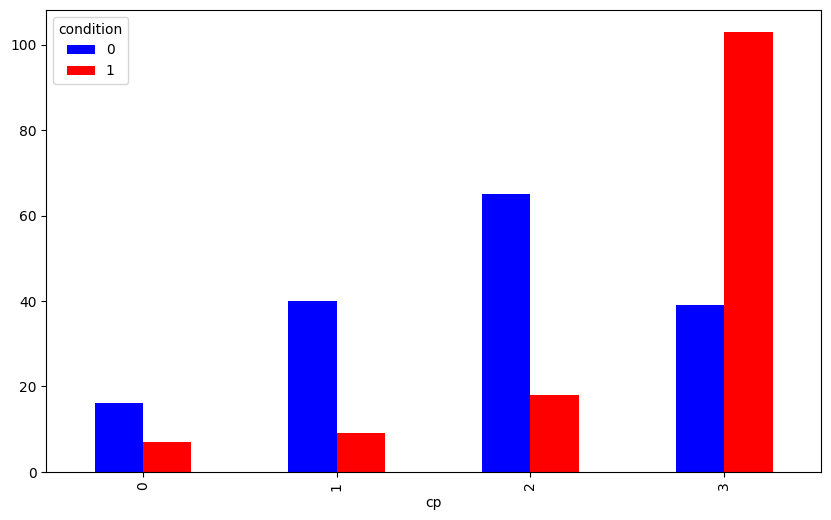

In [6]:
#Mostra a relação do tipo de dor no peito com ter ou não uma doença cardíaca
#-- Value 0: typical angina 
#-- Value 1: atypical angina 
#-- Value 2: non-anginal pain 
#-- Value 3: asymptomatic 
pd.crosstab(df["cp"], df["condition"]).plot(kind="bar",
                                            figsize = (10,6),
                                            color = ["blue", "red"])

MODELAGEM DE DADOS

In [7]:
#Como quero prever se tem ou não doença cardiaca, eu isolo a coluna conditon e zalvo os valores dela para consultas
x = df.drop("condition", axis=1)
y = df["condition"]

Treino e Teste

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
#Dividindo conjunto de treinamento e conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [10]:
#Tamanho de test e train
len(x_train), len(y_train)
len(x_test), len(y_test)

(60, 60)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
#O objetivo deste bloco é comparar o desempenho dos 3 algoritimos, RandomForest, KNN e LogisticRegression  
#Esse dicionario nomeia cada biblioteca importada
models = {"KNN": KNeighborsClassifier(),
           "Logistic Regression": LogisticRegression(),
           "Random Forest": RandomForestClassifier()}

def fit_and_score(models, x_train, x_test, y_train, y_test):
    modelScore = {} #armazena as pontuações de desempenho de cada modelo

    for name, model in models.items(): #Itera sobre cada chave do "models"
        model.fit(x_train, y_train) #Treina a instância do modelo atual usando os dados de treinamento
        modelScore[name] = model.score(x_test, y_test) #Calcula a pontuação do modelo treinado no conjunto de dados de teste.

    return modelScore #Finaliza a função retornando o dicionário "modelScore"

In [13]:
fit_and_score(models  = models,
              x_train = x_train,
              x_test  = x_test,
              y_train = y_train,
              y_test  = y_test)


C:\Users\iagoa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'KNN': 0.65, 'Logistic Regression': 0.85, 'Random Forest': 0.8333333333333334}

AJUSTES DE HIPERPARÂMETROS E VALIDAÇÃO CRUZADA

In [14]:
train_scores = []
test_scores = []

neighbors = range(1, 21)
knn = KNeighborsClassifier()

#A cada iteração, ele muda o número de vizinhos (n_neighbors) que o KNN vai considerar
for i in neighbors:
    knn.set_params(n_neighbors = 1)

    #Treina o modelo e calcula os scores
    knn.fit(x_train, y_train)
    train_scores.append(knn.score(x_train, y_train))
    test_scores.append(knn.score(x_test, y_test))
    

In [15]:
print(f"Desempenho maximo de KNN nos dados de teste: {max(test_scores)*100:.2f}%")

Desempenho maximo de KNN nos dados de teste: 63.33%


RandomizedSearchCV

In [16]:
logreg_grid = {"C": np.logspace(-1, 4, 20), #Esse dicionário define as combinações de parâmetros que serão testadas para o modelo
               "solver": ["liblinear"]} #
rf_grid = {"n_estimators": np.arange(10, 1000, 50), #Esse dicionário define os valores a testar para o modelo RandomForestClassifier
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}



In [17]:
from sklearn.model_selection import RandomizedSearchCV

In [18]:
 #Este bloco vai aplicar busca aleatória de hiperparâmetros para o modelo Regressão Logística
rscv_log_reg = RandomizedSearchCV(LogisticRegression(), 
                                  param_distributions = logreg_grid,
                                  cv = 5,
                                  n_iter = 20,
                                  verbose = True)
rscv_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,LogisticRegression()
,param_distributions,"{'C': array([1.0000...00000000e+04]), 'solver': ['liblinear']}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [19]:
#estou 20 combinações aleatórias dos hiperparâmetros da Regressão Logística e encontrou os melhores parametros
rscv_log_reg.best_params_

{'solver': 'liblinear', 'C': np.float64(2.0691380811147893)}

In [20]:
#Score de acurácia do melhor modelo encontrado
rscv_log_reg.score(x_test, y_test)

0.8666666666666667

In [21]:
 #Este bloco vai aplicar busca aleatória de hiperparâmetros para o modelo RandomForestClassifier
rscv_rf = RandomizedSearchCV(RandomForestClassifier(),
                            param_distributions = rf_grid,
                            cv = 5,
                            n_iter = 20,
                            verbose = True)
rscv_rf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': [None, 3, ...], 'min_samples_leaf': array([ 1, 3..., 15, 17, 19]), 'min_samples_split': array([ 2, 4..., 14, 16, 18]), 'n_estimators': array([ 10, ...60, 910, 960])}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [22]:
#Encontra os melhores parâmetros
rscv_rf.best_params_

{'n_estimators': np.int64(160),
 'min_samples_split': np.int64(2),
 'min_samples_leaf': np.int64(9),
 'max_depth': 3}

In [23]:
#Score de acurácia do melhor modelo encontrado
rscv_rf.score(x_test, y_test)

0.8333333333333334

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
#implementa uma Busca em Grade com Validação Cruzada para otimizar um modelo de classificação Regressão Logística
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid = logreg_grid,
                          cv = 5,
                          verbose = True)
gs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,LogisticRegression()
,param_grid,"{'C': array([1.0000...00000000e+04]), 'solver': ['liblinear']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [26]:
#Encontra os melhores parâmetros
gs_log_reg.best_params_

{'C': np.float64(2.0691380811147893), 'solver': 'liblinear'}

In [33]:
#Score de acurácia do melhor modelo encontrado
gs_log_reg.score(x_test, y_test)

filename = 'sprint4.pkl'
pickle.dump(gs_log_reg, open(filename, 'wb'))

In [28]:
from sklearn.metrics import classification_report

In [29]:
#O bloco utiliza o melhor modelo de Random Forest encontrado para fazer previsões sobre o x_test, e armazena essas previsões em y_preds
y_preds = rscv_rf.predict(x_test)

Text(-1.2499999999999982, 0.5, 'rótulos previstos')

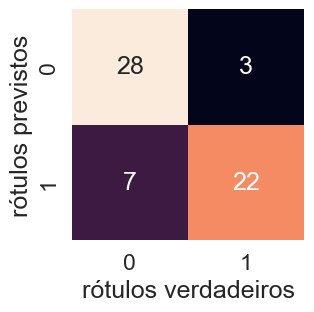

In [30]:
from sklearn.metrics import confusion_matrix

#Mostra uma tablea de falsos positivos
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize = (3, 3))
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                 annot = True,
                 cbar = False)
plt.xlabel("rótulos verdadeiros")
plt.ylabel("rótulos previstos")

Em 4 ocasiões o modelo leu 0 quando deveria ter previsto 1
Em 7 ocasiões o modelo leu 1 quandp deveria ser 0

Relatorio de Classificação

In [31]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        31
           1       0.88      0.76      0.81        29

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



precision:
Mostra a taxa de acerto do modelo

recall:
Identificador de proporção de positivos reais 

f1-score:
É a junção de precision e recall

support:
Numero total de amostras

accuracy:
Precisão do modelo

macro avg:
Média de precision, recal e f1-score

wighted avg:
Média ponderada de precision, recal e f1-score





ANÁLISE DOS MODELOS TREINADOS

Desempenho máximo nos dados de teste: 55% (pior resultado)

Logistic Regression

RandomizedSearchCV: 75% de acurácia
GridSearchCV: 75% de acurácia
Melhores parâmetros: C=0.1, solver='liblinear'

Random Forest

RandomizedSearchCV: 73.33% de acurácia
Melhores parâmetros:

n_estimators=210
max_depth=3
min_samples_split=14
min_samples_leaf=19



🏆 Melhor Modelo: Logistic Regression
Por que a Regressão Logística foi superior?

Maior acurácia: 75% vs 73.33% (Random Forest) vs 55% (KNN)
Melhor balanço precision/recall:

Classe 0: precision=0.63, recall=0.88
Classe 1: precision=0.88, recall=0.63


Consistência: Manteve 75% de acurácia tanto com RandomizedSearchCV quanto GridSearchCV
Matriz de Confusão:

22 previsões corretas de "não tem doença cardíaca"
22 previsões corretas de "tem doença cardíaca"
7 falsos positivos
4 falsos negativos